# Collaborative Filtering

In [290]:
import warnings
warnings.filterwarnings('ignore')

In [291]:
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process  # to match the string value
import matplotlib.pyplot as plt
import seaborn as sns

In [292]:
df_movies=pd.read_csv('movies.csv', usecols=['movieId','title'], dtype={'movieId':'int32','title':'str'})
df_ratings=pd.read_csv('ratings.csv', usecols=['userId','movieId','rating'],dtype={'userId':'int32','movieId':'int32','rating':'float32'})

In [293]:
df_movies.head()

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [294]:
df_movies.shape

(9742, 2)

In [295]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int32 
 1   title    9742 non-null   object
dtypes: int32(1), object(1)
memory usage: 114.3+ KB


In [296]:
df_ratings.sample(5)

,userId,movieId,rating
49449,318,49396,3.5
38284,263,1120,4.0
95558,600,3083,4.0
80886,510,1466,2.0
83489,532,293,3.0


In [297]:
df_ratings.shape

(100836, 3)

In [298]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int32  
 1   movieId  100836 non-null  int32  
 2   rating   100836 non-null  float32
dtypes: float32(1), int32(2)
memory usage: 1.2 MB


In [299]:
df_movies.describe()

,movieId
count,9742.000000
mean,42200.353623
std,52160.494854
min,1.000000
25%,3248.250000
50%,7300.000000
75%,76232.000000
max,193609.000000


In [300]:
df_movies.describe(include = 'object')

,title
count,9742
unique,9737
top,Emma (1996)
freq,2


In [301]:
df_ratings.describe()

,userId,movieId,rating
count,100836.000000,100836.000000,100836.000000
mean,326.127564,19435.295718,3.501557
std,182.618491,35530.987199,1.042541
min,1.000000,1.000000,0.500000
25%,177.000000,1199.000000,3.000000
50%,325.000000,2991.000000,3.500000
75%,477.000000,8122.000000,4.000000
max,610.000000,193609.000000,5.000000


In [302]:
#Sparse Matrix
#         Users
#        [4,4,5] A
#Movies  [3,3,4] B ==   Cos(A,B) => 0.95 
#       [3,2,1]

movies_users=df_ratings.pivot(index='movieId', columns='userId',values='rating')
movies_users

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,...,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,...,4.0,4.0,NaN,3.0,2.5,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,2.5,4.0,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
3,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.5,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193583,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
193585,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [303]:
movies_users=df_ratings.pivot(index='movieId', columns='userId',values='rating').fillna(0)
# pivot table
movies_users

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,...,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5,...,4.0,4.0,0.0,3.0,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.5,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193581,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
193585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [304]:
df_movies.isnull().sum()

movieId    0
title      0
dtype: int64

In [305]:
df_ratings.isnull().sum()

userId     0
movieId    0
rating     0
dtype: int64

In [306]:
mat_movies_users=csr_matrix(movies_users.values)
print(mat_movies_users)

  (0, 0)	4.0
  (0, 4)	4.0
  (0, 6)	4.5
  (0, 14)	2.5
  (0, 16)	4.5
  (0, 17)	3.5
  (0, 18)	4.0
  (0, 20)	3.5
  (0, 26)	3.0
  (0, 30)	5.0
  (0, 31)	3.0
  (0, 32)	3.0
  (0, 39)	5.0
  (0, 42)	5.0
  (0, 43)	3.0
  (0, 44)	4.0
  (0, 45)	5.0
  (0, 49)	3.0
  (0, 53)	3.0
  (0, 56)	5.0
  (0, 62)	5.0
  (0, 63)	4.0
  (0, 65)	4.0
  (0, 67)	2.5
  (0, 70)	5.0
  :	:
  (9700, 337)	2.5
  (9701, 337)	3.0
  (9702, 183)	4.0
  (9702, 247)	3.5
  (9703, 317)	2.5
  (9704, 209)	1.0
  (9705, 461)	2.5
  (9706, 49)	3.5
  (9707, 337)	1.5
  (9708, 337)	4.0
  (9709, 337)	1.0
  (9710, 337)	1.5
  (9711, 337)	1.0
  (9712, 337)	1.0
  (9713, 183)	4.5
  (9714, 183)	3.5
  (9715, 183)	3.0
  (9716, 183)	4.0
  (9717, 183)	4.0
  (9718, 183)	3.5
  (9719, 183)	4.0
  (9720, 183)	3.5
  (9721, 183)	3.5
  (9722, 183)	3.5
  (9723, 330)	4.0


In [307]:
# Cosine Similarity
model_knn= NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20)

In [308]:
model_knn

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=20)

In [309]:
model_knn.fit(mat_movies_users)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=20)

In [310]:
def recommender(movie_name, data,model, n_recommendations ):
    print(model.fit(data))

In [311]:
recommender(input('Enter the Movie Name : '), mat_movies_users, model_knn,20)

Enter the Movie Name : spider man
NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=20)


In [312]:
def recommender(movie_name, data,model, n_recommendations ):
    print(model.fit(data))
    print(process.extractOne(movie_name, df_movies['title']))
    idx = process.extractOne(movie_name, df_movies['title'])[2]
    print(idx)

In [313]:
recommender(input('Enter the Movie Name : '), mat_movies_users, model_knn,20)

Enter the Movie Name : spiderman
NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=20)
('Spider-Man (2002)', 80, 3819)
3819


## Movie Recommendation System

In [314]:
# Recommender(movie_name) => List of Movies recommended

def recommender(movie_name, data,model, n_recommendations ):
    model.fit(data)
    idx=process.extractOne(movie_name, df_movies['title'])[2]
    print('Movie Selected: ',df_movies['title'][idx], 'Index: ',idx)
    print('Recommended Movies : ')
    distances, indices=model.kneighbors(data[idx], n_neighbors=n_recommendations)
    for i in indices:
        print(df_movies['title'][i])
    
recommender(input('Enter the Movie Name : '), mat_movies_users, model_knn,20)

Enter the Movie Name : spider man
Movie Selected:  Spider-Man (2002) Index:  3819
Recommended Movies : 
3819                                    Spider-Man (2002)
1611                                 Avengers, The (1998)
5564        Riki-Oh: The Story of Ricky (Lik Wong) (1991)
5386                     Christmas with the Kranks (2004)
4703                                     Project X (1987)
5205    Human Condition I, The (Ningen no joken I) (1959)
3546                          Spriggan (Supurigan) (1998)
2858                            Autumn in New York (2000)
3390                                           K-9 (1989)
3941                                    Swarm, The (1978)
3419                 Return of the Musketeers, The (1989)
6268                                   Half Nelson (2006)
9185                                    Spellbound (2011)
5552                                        Ju Dou (1990)
7310    Mortadelo & Filemon: The Big Adventure (La gra...
5483                      

# Content Based Filtering

In [315]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import difflib  #to find closest value in the dataset
from sklearn.feature_extraction.text import TfidfVectorizer #to convert text into feature vectors
from sklearn.metrics.pairwise import cosine_similarity #to find similarity score

In [316]:
pd.set_option('display.max_columns',30)
df_movies = pd.read_csv('moviesdata.csv')

In [317]:
df_movies.sample(5)

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
4679,4679,0,Documentary,NaN,287815,NaN,en,Call + Response,Call + Response is a first of its kind feature...,0.062089,[],[],2008-10-10,0,86.0,[],Released,A FILM ABOUT THE WORLD'S 27 MILLION MOST TERRI...,Call + Response,8.0,1,NaN,"[{'name': 'Justin Dillon', 'gender': 0, 'depar...",Justin Dillon
679,679,64000000,Comedy Crime,http://www.littleman-movie.com/,9072,baby adoption married couple small person crim...,en,Little Man,"After leaving the prison, the dwarf criminal C...",12.421504,"[{""name"": ""Revolution Studios"", ""id"": 497}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2006-08-31,101595121,98.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Big things come in small packages,Little Man,5.3,261,Marlon Wayans Shawn Wayans Kerry Washington Jo...,"[{'name': 'Lisa Beach', 'gender': 1, 'departme...",Keenen Ivory Wayans
4703,4703,150000,Comedy Drama Romance,NaN,39141,independent film,en,Tadpole,"Beautiful, sophisticated women are all over Os...",8.570328,"[{""name"": ""IFC Productions"", ""id"": 26468}, {""n...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2002-11-01,2891288,78.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Everyone says he should date girls his own age...,Tadpole,5.5,19,Aaron Stanford Kate Mara Bebe Neuwirth John Ri...,"[{'name': 'John Sloss', 'gender': 2, 'departme...",Gary Winick
3276,3276,8000000,Comedy Drama,http://focusfeatures.com/its_kind_of_a_funny_s...,43923,suicide depression independent film coming of ...,en,It's Kind of a Funny Story,A clinically depressed teenager gets a new sta...,13.143045,"[{""name"": ""Focus Features"", ""id"": 10146}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2010-07-06,6491240,101.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Sometimes what's in your head isn't as crazy a...,It's Kind of a Funny Story,6.9,672,Keir Gilchrist Emma Roberts Zach Galifianakis ...,"[{'name': 'Carrie Stewart', 'gender': 0, 'depa...",Ryan Fleck
3999,3999,2159280,Drama,NaN,209274,nun mine jew jewish poland,pl,Ida,"Poland, 1962. Anna is a novice, an orphan brou...",13.265432,"[{""name"": ""Danish Film Institute"", ""id"": 125},...","[{""iso_3166_1"": ""DK"", ""name"": ""Denmark""}, {""is...",2013-10-25,10700000,80.0,"[{""iso_639_1"": ""pl"", ""name"": ""Polski""}]",Released,NaN,Ida,7.1,260,Agata Trzebuchowska Agata Kulesza Joanna Kulig...,"[{'name': 'Kristian Eidnes Andersen', 'gender'...",Pawe\u0142 Pawlikowski


In [318]:
# number of rows and columns in the data frame
df_movies.shape

(4803, 24)

In [319]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4803 entries, 0 to 4802
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   index                 4803 non-null   int64  
 1   budget                4803 non-null   int64  
 2   genres                4775 non-null   object 
 3   homepage              1712 non-null   object 
 4   id                    4803 non-null   int64  
 5   keywords              4391 non-null   object 
 6   original_language     4803 non-null   object 
 7   original_title        4803 non-null   object 
 8   overview              4800 non-null   object 
 9   popularity            4803 non-null   float64
 10  production_companies  4803 non-null   object 
 11  production_countries  4803 non-null   object 
 12  release_date          4802 non-null   object 
 13  revenue               4803 non-null   int64  
 14  runtime               4801 non-null   float64
 15  spoken_languages     

In [320]:
df_float = df_movies.describe(include='float64')
df_float

,popularity,runtime,vote_average
count,4803.000000,4801.000000,4803.000000
mean,21.492301,106.875859,6.092172
std,31.816650,22.611935,1.194612
min,0.000000,0.000000,0.000000
25%,4.668070,94.000000,5.600000
50%,12.921594,103.000000,6.200000
75%,28.313505,118.000000,6.800000
max,875.581305,338.000000,10.000000


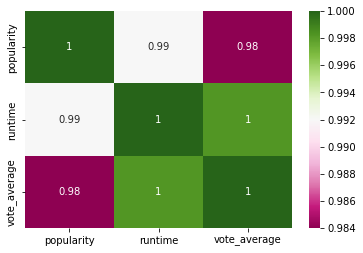

In [321]:
corr = df_float.corr()
plt.figure(figsize=(6,4))
sns.heatmap(corr, cmap='PiYG', annot=True)
plt.show()

In [322]:
df_int = df_movies.describe(include='int64')
df_int

,index,budget,id,revenue,vote_count
count,4803.000000,4.803000e+03,4803.000000,4.803000e+03,4803.000000
mean,2401.000000,2.904504e+07,57165.484281,8.226064e+07,690.217989
std,1386.651002,4.072239e+07,88694.614033,1.628571e+08,1234.585891
min,0.000000,0.000000e+00,5.000000,0.000000e+00,0.000000
25%,1200.500000,7.900000e+05,9014.500000,0.000000e+00,54.000000
50%,2401.000000,1.500000e+07,14629.000000,1.917000e+07,235.000000
75%,3601.500000,4.000000e+07,58610.500000,9.291719e+07,737.000000
max,4802.000000,3.800000e+08,459488.000000,2.787965e+09,13752.000000


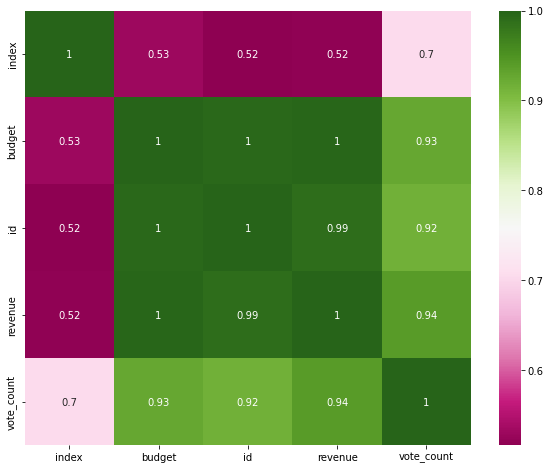

In [323]:
corr = df_int.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='PiYG', annot=True)
plt.show()

In [324]:
df_object = df_movies.describe(include= 'object')
df_object

,genres,homepage,keywords,original_language,original_title,overview,production_companies,production_countries,release_date,spoken_languages,status,tagline,title,cast,crew,director
count,4775,1712,4391,4803,4803,4800,4803,4803,4802,4803,4803,3959,4803,4760,4803,4773
unique,1168,1691,4219,37,4801,4800,3697,469,3280,544,3,3944,4800,4741,4776,2349
top,Drama,http://www.missionimpossible.com/,independent film,en,Out of the Blue,"In the 22nd century, a paraplegic Marine is di...",[],"[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2006-01-01,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,Based on a true story.,The Host,William Shatner Leonard Nimoy DeForest Kelley ...,[],Steven Spielberg
freq,370,4,55,4505,2,1,351,2977,10,3171,4795,3,2,6,28,27


In [325]:
# selecting relevant features for movie suggestion
selected_features = ['genres','keywords','tagline','cast','director']

# replacing the null values with null string
for sf in selected_features:
    df_movies[sf] = df_movies[sf].fillna('')

In [326]:
df_movies.isnull().sum()

index                      0
budget                     0
genres                     0
homepage                3091
id                         0
keywords                   0
original_language          0
original_title             0
overview                   3
popularity                 0
production_companies       0
production_countries       0
release_date               1
revenue                    0
runtime                    2
spoken_languages           0
status                     0
tagline                    0
title                      0
vote_average               0
vote_count                 0
cast                       0
crew                       0
director                   0
dtype: int64

In [327]:
# combining all the selected features
combined_features = df_movies['genres']+' '+df_movies['keywords']+' '+df_movies['tagline']+' '+df_movies['cast']+' '+df_movies['director']

In [328]:
combined_features

0       Action Adventure Fantasy Science Fiction cultu...
1       Adventure Fantasy Action ocean drug abuse exot...
2       Action Adventure Crime spy based on novel secr...
3       Action Crime Drama Thriller dc comics crime fi...
4       Action Adventure Science Fiction based on nove...
                              ...                        
4798    Action Crime Thriller united states\u2013mexic...
4799    Comedy Romance  A newlywed couple's honeymoon ...
4800    Comedy Drama Romance TV Movie date love at fir...
4801      A New Yorker in Shanghai Daniel Henney Eliza...
4802    Documentary obsession camcorder crush dream gi...
Length: 4803, dtype: object

In [329]:
#convert text data into numerical characters/feature vectors
vectorizer = TfidfVectorizer()
feature_vectors = vectorizer.fit_transform(combined_features)
print(feature_vectors)

  (0, 2432)	0.17272411194153
  (0, 7755)	0.1128035714854756
  (0, 13024)	0.1942362060108871
  (0, 10229)	0.16058685400095302
  (0, 8756)	0.22709015857011816
  (0, 14608)	0.15150672398763912
  (0, 16668)	0.19843263965100372
  (0, 14064)	0.20596090415084142
  (0, 13319)	0.2177470539412484
  (0, 17290)	0.20197912553916567
  (0, 17007)	0.23643326319898797
  (0, 13349)	0.15021264094167086
  (0, 11503)	0.27211310056983656
  (0, 11192)	0.09049319826481456
  (0, 16998)	0.1282126322850579
  (0, 15261)	0.07095833561276566
  (0, 4945)	0.24025852494110758
  (0, 14271)	0.21392179219912877
  (0, 3225)	0.24960162956997736
  (0, 16587)	0.12549432354918996
  (0, 14378)	0.33962752210959823
  (0, 5836)	0.1646750903586285
  (0, 3065)	0.22208377802661425
  (0, 3678)	0.21392179219912877
  (0, 5437)	0.1036413987316636
  :	:
  (4801, 17266)	0.2886098184932947
  (4801, 4835)	0.24713765026963996
  (4801, 403)	0.17727585190343226
  (4801, 6935)	0.2886098184932947
  (4801, 11663)	0.21557500762727902
  (4801, 1672

In [330]:
#Cosine Similarity Score
similarity = cosine_similarity(feature_vectors)
similarity

array([[1.        , 0.07219487, 0.037733  , ..., 0.        , 0.        ,
        0.        ],
       [0.07219487, 1.        , 0.03281499, ..., 0.03575545, 0.        ,
        0.        ],
       [0.037733  , 0.03281499, 1.        , ..., 0.        , 0.05389661,
        0.        ],
       ...,
       [0.        , 0.03575545, 0.        , ..., 1.        , 0.        ,
        0.02651502],
       [0.        , 0.        , 0.05389661, ..., 0.        , 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.02651502, 0.        ,
        1.        ]])

In [331]:
similarity.shape

(4803, 4803)

In [332]:
# getting movie name from the user
movie_name = input('Enter the movie name: ')

Enter the movie name: iron man


In [333]:
#Creating a list with all the movie titles present in the dataset
title_list = df_movies['title'].tolist()
title_list

['Avatar',
 "Pirates of the Caribbean: At World's End",
 'Spectre',
 'The Dark Knight Rises',
 'John Carter',
 'Spider-Man 3',
 'Tangled',
 'Avengers: Age of Ultron',
 'Harry Potter and the Half-Blood Prince',
 'Batman v Superman: Dawn of Justice',
 'Superman Returns',
 'Quantum of Solace',
 "Pirates of the Caribbean: Dead Man's Chest",
 'The Lone Ranger',
 'Man of Steel',
 'The Chronicles of Narnia: Prince Caspian',
 'The Avengers',
 'Pirates of the Caribbean: On Stranger Tides',
 'Men in Black 3',
 'The Hobbit: The Battle of the Five Armies',
 'The Amazing Spider-Man',
 'Robin Hood',
 'The Hobbit: The Desolation of Smaug',
 'The Golden Compass',
 'King Kong',
 'Titanic',
 'Captain America: Civil War',
 'Battleship',
 'Jurassic World',
 'Skyfall',
 'Spider-Man 2',
 'Iron Man 3',
 'Alice in Wonderland',
 'X-Men: The Last Stand',
 'Monsters University',
 'Transformers: Revenge of the Fallen',
 'Transformers: Age of Extinction',
 'Oz: The Great and Powerful',
 'The Amazing Spider-Man 2',

In [334]:
#finding the close match of the movie name which is given by the user
find_close_match = difflib.get_close_matches(movie_name, title_list)
find_close_match

['Iron Man', 'Iron Man 3', 'Iron Man 2']

In [335]:
close_match = find_close_match[0]
close_match

'Iron Man'

In [336]:
# finding the index of the movie with title
movie_index = df_movies[df_movies.title == close_match]['index'].values[0]
movie_index

68

In [337]:
# getting a list of similar movies based on similarity score
similarity_score = list(enumerate(similarity[movie_index]))
similarity_score

[(0, 0.033570748780675445),
 (1, 0.0546448279236134),
 (2, 0.013735500604224323),
 (3, 0.006468756104392058),
 (4, 0.03268943310073386),
 (5, 0.013907256685755473),
 (6, 0.07692837576335507),
 (7, 0.23944423963486405),
 (8, 0.007882387851851008),
 (9, 0.07599206098164225),
 (10, 0.07536074882460438),
 (11, 0.01192606921174529),
 (12, 0.013707618139948929),
 (13, 0.012376074925089967),
 (14, 0.09657127116284188),
 (15, 0.007286271383816743),
 (16, 0.22704403782296803),
 (17, 0.013112928084103857),
 (18, 0.04140526820609594),
 (19, 0.07883282546834255),
 (20, 0.07981173664799915),
 (21, 0.011266873271064948),
 (22, 0.006892575895462364),
 (23, 0.006599097891242659),
 (24, 0.012665208122549737),
 (25, 0.0),
 (26, 0.21566241096831154),
 (27, 0.030581282093826635),
 (28, 0.061074402219665376),
 (29, 0.014046184258938898),
 (30, 0.0807734659476981),
 (31, 0.31467052449477506),
 (32, 0.02878209913426701),
 (33, 0.13089810941050173),
 (34, 0.0),
 (35, 0.035350090674865595),
 (36, 0.03185325269

In [338]:
#to find highest similarity score sorting the movies based on their similarity score
sorted_similar_movies = sorted(similarity_score, key = lambda x:x[1], reverse = True) 
print(sorted_similar_movies)

[(68, 1.0000000000000002), (79, 0.40890433998005965), (31, 0.31467052449477506), (7, 0.23944423963486405), (16, 0.22704403782296803), (26, 0.21566241096831154), (85, 0.20615862984665329), (182, 0.19573956139611606), (511, 0.16702973947860686), (3623, 0.1609246088135586), (64, 0.15299924139445145), (203, 0.14818667948665118), (174, 0.1471993120942043), (4401, 0.14505971470107848), (101, 0.14401677581826294), (46, 0.14216268867232237), (169, 0.1380947013224906), (1740, 0.13624382641690763), (94, 0.1361681957902901), (788, 0.1330589507422922), (126, 0.13263982780511066), (131, 0.13137698586006535), (33, 0.13089810941050173), (2487, 0.12309731939910507), (783, 0.12162995562040377), (138, 0.11846458075866884), (2442, 0.11725512335483321), (661, 0.11719294096248463), (607, 0.11387063493435637), (38, 0.1126182690487113), (2651, 0.1121878787373205), (353, 0.1116846512704428), (122, 0.10850296033661253), (1553, 0.1079782217151326), (1451, 0.107849394974707), (242, 0.10630339022327012), (618, 0.

In [339]:
res = [lis[1] for lis in sorted_similar_movies]
res

[1.0000000000000002,
 0.40890433998005965,
 0.31467052449477506,
 0.23944423963486405,
 0.22704403782296803,
 0.21566241096831154,
 0.20615862984665329,
 0.19573956139611606,
 0.16702973947860686,
 0.1609246088135586,
 0.15299924139445145,
 0.14818667948665118,
 0.1471993120942043,
 0.14505971470107848,
 0.14401677581826294,
 0.14216268867232237,
 0.1380947013224906,
 0.13624382641690763,
 0.1361681957902901,
 0.1330589507422922,
 0.13263982780511066,
 0.13137698586006535,
 0.13089810941050173,
 0.12309731939910507,
 0.12162995562040377,
 0.11846458075866884,
 0.11725512335483321,
 0.11719294096248463,
 0.11387063493435637,
 0.1126182690487113,
 0.1121878787373205,
 0.1116846512704428,
 0.10850296033661253,
 0.1079782217151326,
 0.107849394974707,
 0.10630339022327012,
 0.1025469263536857,
 0.10087565815879387,
 0.10006436988307142,
 0.09911415072466837,
 0.09877044853778177,
 0.0986387254713941,
 0.09829572149918514,
 0.09760018407279153,
 0.09657127116284188,
 0.09574351274416697,
 0

In [340]:
df_score = pd.DataFrame({'Scores':res})
print (df_score)

        Scores
0     1.000000
1     0.408904
2     0.314671
3     0.239444
4     0.227044
...        ...
4798  0.000000
4799  0.000000
4800  0.000000
4801  0.000000
4802  0.000000

[4803 rows x 1 columns]


In [341]:
df_score['Scores']

0       1.000000
1       0.408904
2       0.314671
3       0.239444
4       0.227044
          ...   
4798    0.000000
4799    0.000000
4800    0.000000
4801    0.000000
4802    0.000000
Name: Scores, Length: 4803, dtype: float64

In [342]:
# suggest the name of similar movies based on the index
print('Movies suggested for you : \n')

i = 0

for movie in sorted_similar_movies:
  index = movie[0]
  title_from_index = df_movies[df_movies.index==index]['title'].values[0]
  if (i<20):
    print(i, '.',title_from_index)
    i+=1

Movies suggested for you : 

0 . Iron Man
1 . Iron Man 2
2 . Iron Man 3
3 . Avengers: Age of Ultron
4 . The Avengers
5 . Captain America: Civil War
6 . Captain America: The Winter Soldier
7 . Ant-Man
8 . X-Men
9 . Made
10 . X-Men: Apocalypse
11 . X2
12 . The Incredible Hulk
13 . The Helix... Loaded
14 . X-Men: First Class
15 . X-Men: Days of Future Past
16 . Captain America: The First Avenger
17 . Kick-Ass 2
18 . Guardians of the Galaxy
19 . Deadpool


## Movie Recommendation System

In [343]:
movie_name = input(' Enter the movie name : ')

title_list = df_movies['title'].tolist()

find_close_match = difflib.get_close_matches(movie_name, title_list)

close_match = find_close_match[0]

movie_index = df_movies[df_movies.title == close_match]['index'].values[0]

similarity_score = list(enumerate(similarity[movie_index]))

sorted_similar_movies = sorted(similarity_score, key = lambda x:x[1], reverse = True) 

print('Recommended Movies : \n')

i = 1

for movie in sorted_similar_movies:
  index = movie[0]
  title_from_index = df_movies[df_movies.index==index]['title'].values[0]
  if (i<20):
    print(i, '.',title_from_index)
    i+=1

 Enter the movie name : iron man
Recommended Movies : 

1 . Iron Man
2 . Iron Man 2
3 . Iron Man 3
4 . Avengers: Age of Ultron
5 . The Avengers
6 . Captain America: Civil War
7 . Captain America: The Winter Soldier
8 . Ant-Man
9 . X-Men
10 . Made
11 . X-Men: Apocalypse
12 . X2
13 . The Incredible Hulk
14 . The Helix... Loaded
15 . X-Men: First Class
16 . X-Men: Days of Future Past
17 . Captain America: The First Avenger
18 . Kick-Ass 2
19 . Guardians of the Galaxy


# Popularity Based Filtering

In [344]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [345]:
movies = pd.read_csv('movies.csv', index_col=None, usecols=['movieId','title'], dtype={'movieId':'int32','title':'str'})
ratings = pd.read_csv('ratings.csv', index_col=None, usecols=['userId','movieId','rating'],dtype={'userId':'int32','movieId':'int32','rating':'float32'})

In [346]:
movies.head(5)

,movieId,title
0,1,Toy Story (1995)
1,2,Jumanji (1995)
2,3,Grumpier Old Men (1995)
3,4,Waiting to Exhale (1995)
4,5,Father of the Bride Part II (1995)


In [347]:
movies.shape

(9742, 2)

In [348]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int32 
 1   title    9742 non-null   object
dtypes: int32(1), object(1)
memory usage: 114.3+ KB


In [349]:
ratings.head(5)

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [350]:
ratings.shape

(100836, 3)

In [351]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   userId   100836 non-null  int32  
 1   movieId  100836 non-null  int32  
 2   rating   100836 non-null  float32
dtypes: float32(1), int32(2)
memory usage: 1.2 MB


In [352]:
dataset = pd.merge(movies, ratings, how='left', on='movieId')
dataset = dataset.fillna(0)

In [353]:
dataset.sample(6)

,movieId,title,userId,rating
13721,502,"Next Karate Kid, The (1994)",146.0,2.5
2454,50,"Usual Suspects, The (1995)",237.0,2.5
32975,1580,Men in Black (a.k.a. MIB) (1997),187.0,2.0
47049,2710,"Blair Witch Project, The (1999)",542.0,0.5
82912,46723,Babel (2006),414.0,4.0
60235,4105,"Evil Dead, The (1981)",274.0,4.0


In [354]:
dataset.shape

(100854, 4)

In [355]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100854 entries, 0 to 100853
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   movieId  100854 non-null  int32  
 1   title    100854 non-null  object 
 2   userId   100854 non-null  float64
 3   rating   100854 non-null  float32
dtypes: float32(1), float64(1), int32(1), object(1)
memory usage: 3.1+ MB


In [356]:
dataset.isnull().sum()

movieId    0
title      0
userId     0
rating     0
dtype: int64

In [357]:
# Total unique users in the dataset
dataset['userId'].nunique()

611

In [358]:
# Total unique movies in the dataset
dataset['movieId'].nunique()

9742

In [359]:
train_data, test_data = train_test_split(dataset, test_size =.30, random_state=10)

In [360]:
# 70% train data
train_data.shape

(70597, 4)

In [361]:
# 30% test data
test_data.shape

(30257, 4)

## Movie Recommendation System

In [362]:
class popularity_model():
    def __init__(self, train_data, test_data, user_id, title):
        self.train_data = train_data
        self.test_data = test_data
        self.user_id = user_id
        self.title = title
        self.popularity_recommendation = None
        
    def fit(self):
        # counting movies with more ratings from users
        train_data_grouped = train_data.groupby([self.title]).agg(self.user_id).count().reset_index()
        train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
    
        # sorting the score column of train_data_grouped in ascending order
        train_data_sort = train_data_grouped.sort_values(['score', self.title], ascending = [0,1])
        
    
        # recommendation rank based on score
        # ranking the highest score with 1 
        train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first')
        
    
        self.popularity_recommendation = train_data_sort
        
    def recommendation(self, user_id, n=20):    
        user_recommendations = self.popularity_recommendation
        
        #getting movies that are rated by the given userId 
        movies_already_rated_by_user = self.train_data.loc[self.train_data[self.user_id] == user_id][self.title]  
       
        # recommending the movies with the highest ratings that havent been rated by the given user
        # `~` refers to all the title that is not in the variable `movies_already_rated_by_user`
        user_recommendations = user_recommendations[~user_recommendations[self.title].isin(movies_already_rated_by_user)]
        
        
        #Add user_id column for which the recommendations are being generated
        user_recommendations['user_id'] = user_id
    
        #Bringing the user_id column to the front
        cols = user_recommendations.columns.tolist()
        user_recommendations = user_recommendations[cols]
        return user_recommendations.head(n)

In [363]:
hr = popularity_model(train_data=train_data, test_data=test_data, user_id='userId', title='title')

In [364]:
# the variable hr has all the highest rated movies
hr.fit()

In [365]:
movie_suggestion = hr.recommendation(input('Enter UserID : '))
movie_suggestion 

Enter UserID : 520


,title,score,Rank,user_id
6701,"Shawshank Redemption, The (1994)",228,1.0,520
2796,Forrest Gump (1994),226,2.0,520
6075,Pulp Fiction (1994),213,3.0,520
4871,"Matrix, The (1999)",192,4.0,520
6780,"Silence of the Lambs, The (1991)",188,5.0,520
4114,Jurassic Park (1993),176,6.0,520
6549,Schindler's List (1993),172,7.0,520
1177,Braveheart (1995),169,8.0,520
7068,Star Wars: Episode IV - A New Hope (1977),160,9.0,520
2661,Fight Club (1999),150,10.0,520


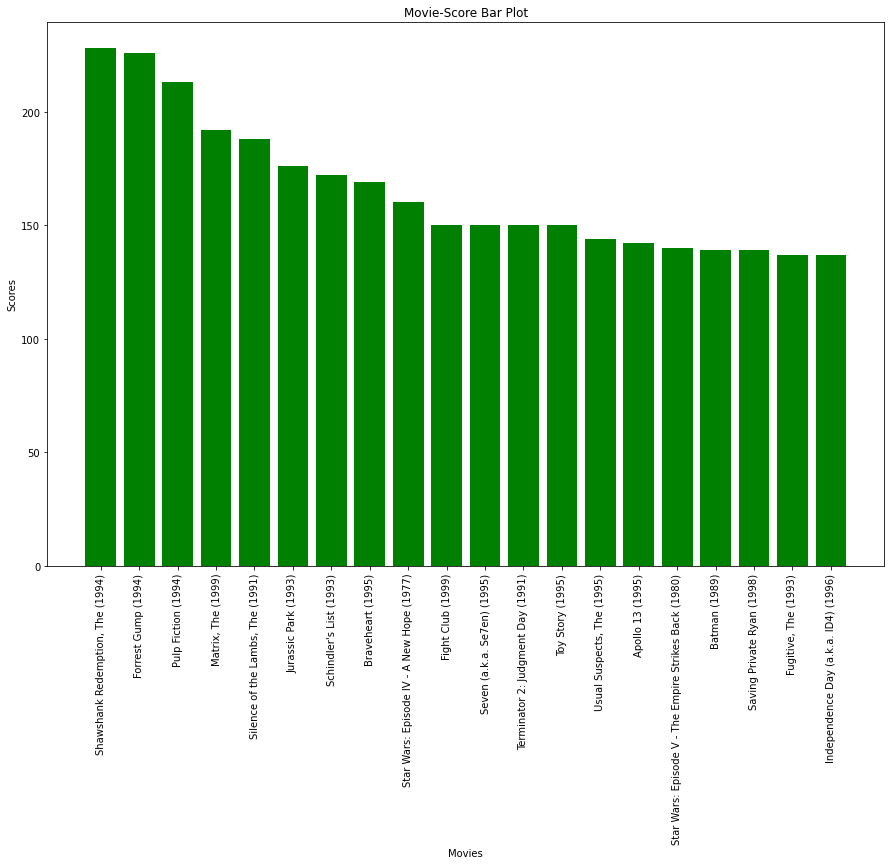

In [366]:
plt.figure(figsize=(15,10))
plt.bar(movie_suggestion['title'],movie_suggestion['score'],align="center",color='green')
plt.xlabel('Movies')
plt.ylabel("Scores")
plt.title('Movie-Score Bar Plot')
plt.xticks(rotation= 90)
plt.show()

In [367]:
print(f'Recommended Movies for Particular User : \n')
print(movie_suggestion [['title', 'user_id']])

Recommended Movies for Particular User : 

                                                  title user_id
6701                   Shawshank Redemption, The (1994)     520
2796                                Forrest Gump (1994)     520
6075                                Pulp Fiction (1994)     520
4871                                 Matrix, The (1999)     520
6780                   Silence of the Lambs, The (1991)     520
4114                               Jurassic Park (1993)     520
6549                            Schindler's List (1993)     520
1177                                  Braveheart (1995)     520
7068          Star Wars: Episode IV - A New Hope (1977)     520
2661                                  Fight Club (1999)     520
6638                        Seven (a.k.a. Se7en) (1995)     520
7384                  Terminator 2: Judgment Day (1991)     520
7822                                   Toy Story (1995)     520
8043                         Usual Suspects, The (1995)     5